In [1]:
from tdc.multi_pred import DTI
from transformers import pipeline
from unsloth import FastLanguageModel
import torch
import seaborn as sns
import os


os.environ["CUDA_VISIBLE_DEVICES"]="7"



🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
data = DTI(name = 'BindingDB_Kd')
data.harmonize_affinities(mode = 'mean')
split = data.get_split()

Found local copy...
Loading...
Done!
The original data has been updated!


In [3]:
template = """### Instructions: Answer the following question about drug target interactions.
### Context: Drug-target binding is the physical interaction between a drug and a specific biological molecule, such as a protein or enzyme. 
This interaction is essential for the drug to exert its pharmacological effect. The strength of the drug-target binding is determined by the binding affinity, 
which is a measure of how tightly the drug binds to the target. Kd is the dissociation constant of a drug-target complex. It is the concentration of drug at which 
half of the drug-target complexes have dissociated. A lower Kd value indicates a stronger binding affinity.
### Question: Given the target amino acid sequence and compound SMILES string, 
predict their normalized binding affinity Kd from 000 to 1000, where 000 is minimum Kd and 1000 is maximum Kd. 

Drug SMILES: {}
Target amino acid sequence: {}
### Answer: {}"""


In [4]:
config  = {
    "model":{
        "name":"unsloth/gemma-2-27b-bnb-4bit",
        "max_seq_len":8096,
        "dtype":None,
        "load_in_4bit":True,
    },
    "model_save":"saved_model",
    "seed":49,
}

In [7]:
split["train"].head()

,Drug_ID,Drug,Target_ID,Target,Y
0,51.0,O=C(O)CCC(=O)C(=O)O,Q9GZT9,MANDSGGPGGPSPSERDRQYCELCGKMENLLRCSRCRSSFYCCKEH...,1450.0
1,187.0,CC(=O)OCC[N+](C)(C)C,P58154,MRRNIFCLACLWIVQACLSLDRADILYNIRQTSRPDVIPTQRDRPV...,2154.0
2,264.0,CCCC(=O)O,Q9Z429,MQQFTIRTRLLMLVGAMFIGFITIELMGFSALQRGVASLNTVYLDR...,92000.0
3,311.0,O=C(O)CC(O)(CC(=O)O)C(=O)O,P15474,MPRSLANAPIMILNGPNLNLLGQRQPEIYGSDTLADVEALCVKAAA...,7300.0
4,525.0,O=C(O)CC(O)C(=O)O,Q9Z429,MQQFTIRTRLLMLVGAMFIGFITIELMGFSALQRGVASLNTVYLDR...,8500.0


(0.0, 10000000.0, 10000.0, 470.0, 10000.0, <Axes: ylabel='Y'>)

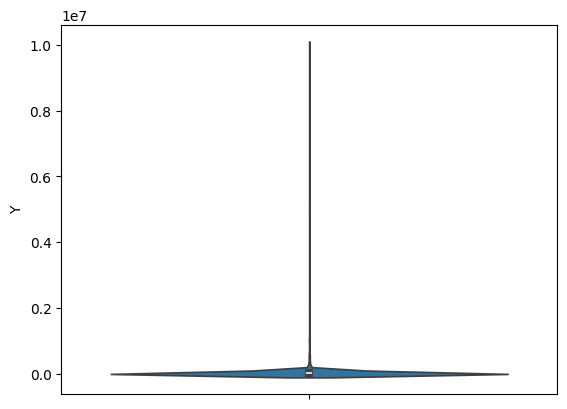

In [8]:
split["train"]["Y"].min(), split["train"]["Y"].max(),split["train"]["Y"].quantile(0.5), split["train"]["Y"].quantile(0.25), split["train"]["Y"].quantile(0.90),sns.violinplot(split["train"]["Y"])

In [9]:
MAX_CUT_OFF = 10000
MIN_CUT_OFF = 0
BINS = 1000  
PER_BIN_COUNT = (MAX_CUT_OFF-MIN_CUT_OFF)//BINS

In [10]:
removed_count_train = ((split["train"]["Y"]<MIN_CUT_OFF) | (split["train"]["Y"]>MAX_CUT_OFF)).sum()
removed_count_valid = ((split["valid"]["Y"]<MIN_CUT_OFF) | (split["valid"]["Y"]>MAX_CUT_OFF)).sum()
removed_count_test = ((split["test"]["Y"]<MIN_CUT_OFF) | (split["test"]["Y"]>MAX_CUT_OFF)).sum()

removed_count_train/split["train"]["Y"].shape[0], removed_count_valid/split["valid"]["Y"].shape[0], removed_count_test/split["test"]["Y"].shape[0]

(0.07755792322002368, 0.08072916666666667, 0.07706878181602936)

In [11]:
split["train"] = split["train"].loc[(split["train"]["Y"]>MIN_CUT_OFF) & (split["train"]["Y"]<MAX_CUT_OFF)]
split["valid"] = split["valid"].loc[(split["valid"]["Y"]>MIN_CUT_OFF) & (split["valid"]["Y"]<MAX_CUT_OFF)]
split["test"] = split["test"].loc[(split["test"]["Y"]>MIN_CUT_OFF) & (split["test"]["Y"]<MAX_CUT_OFF)]

In [12]:
split["train"]["Y"] = split["train"]["Y"].apply(lambda x: x//PER_BIN_COUNT)
split["valid"]["Y"] = split["valid"]["Y"].apply(lambda x: x//PER_BIN_COUNT)
split["test"]["Y"] = split["test"]["Y"].apply(lambda x: x//PER_BIN_COUNT)

(0.0, 995.0, <Axes: xlabel='Y', ylabel='Count'>)

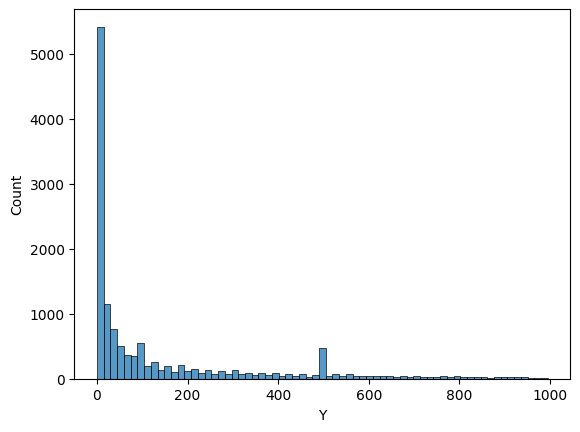

In [13]:
split["train"]["Y"].min(), split["train"]["Y"].max(),sns.histplot(split["train"]["Y"])

In [17]:
# process dataset

def formatting_prompts_func(examples):
    Drug = examples["Drug"]
    Target = examples["Target"]
    outputs       = examples["Y"]
    texts = []
    for p,m,o in zip(Drug, Target, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = template.format(p,m,o)
        texts.append(text)
    return { "text" : texts, "Drug":Drug, "Target":Target, "outputs":outputs, "ds_ident":"DDI"}

def formatting_prompts_func_test(examples):
    Drug = examples["Drug"]
    Target = examples["Target"]
    outputs       = examples["Y"]
    texts = []
    for p,m,o in zip(Drug, Target, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = template.format(p,m,"")
        texts.append(text)
    return { "text" : texts, "Drug":Drug, "Target":Target, "outputs":outputs, "ds_ident":"DDI"}


In [18]:
train_dataset = formatting_prompts_func_test(split["train"])
valid_dataset = formatting_prompts_func_test(split["valid"])
test_dataset = formatting_prompts_func_test(split["test"])

In [19]:
train_dataset["text"]

'### Instructions: Answer the following question about drug target interactions.\n### Context: Drug-target binding is the physical interaction between a drug and a specific biological molecule, such as a protein or enzyme. \nThis interaction is essential for the drug to exert its pharmacological effect. The strength of the drug-target binding is determined by the binding affinity, \nwhich is a measure of how tightly the drug binds to the target. Kd is the dissociation constant of a drug-target complex. It is the concentration of drug at which \nhalf of the drug-target complexes have dissociated. A lower Kd value indicates a stronger binding affinity.\n### Question: Given the target amino acid sequence and compound SMILES string, \npredict their normalized binding affinity Kd from 000 to 1000, where 000 is minimum Kd and 1000 is maximum Kd. \n\nDrug SMILES: O=C(O)CCC(=O)C(=O)O\nTarget amino acid sequence: MANDSGGPGGPSPSERDRQYCELCGKMENLLRCSRCRSSFYCCKEHQRQDWKKHKLVCQGSEGALGHGVGPHQHSGPAPPAA

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = config["model"]["name"],  # or choose "unsloth/Llama-3.2-1B"
    max_seq_length = config["model"]["max_seq_len"], # Choose any! We auto support RoPE Scaling internally!
    dtype = config["model"]["dtype"],# None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
    load_in_4bit = config["model"]["load_in_4bit"], # Use 4bit quantization to reduce memory usage. Can be False.
)

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference

pipe = pipeline(
        task="text-generation", 
        model=model, 
        tokenizer=tokenizer, 
        max_new_tokens=512, 
        temperature=0.1
    )

print("Model Loaded !!!", end="\n\n\n")

### Zero-shot results

In [20]:
results = pipe([train_dataset["text"][0]])

In [30]:
print(results[0][0]["generated_text"])

### Instructions: Answer the following question about drug target interactions.
### Context: Drug-target binding is the physical interaction between a drug and a specific biological molecule, such as a protein or enzyme. 
This interaction is essential for the drug to exert its pharmacological effect. The strength of the drug-target binding is determined by the binding affinity, 
which is a measure of how tightly the drug binds to the target. Kd is the dissociation constant of a drug-target complex. It is the concentration of drug at which 
half of the drug-target complexes have dissociated. A lower Kd value indicates a stronger binding affinity.
### Question: Given the target amino acid sequence and compound SMILES string, 
predict their normalized binding affinity Kd from 000 to 1000, where 000 is minimum Kd and 1000 is maximum Kd. 

Drug SMILES: O=C(O)CCC(=O)C(=O)O
Target amino acid sequence: MANDSGGPGGPSPSERDRQYCELCGKMENLLRCSRCRSSFYCCKEHQRQDWKKHKLVCQGSEGALGHGVGPHQHSGPAPPAAVPPPRAGARE